# Model Comparison v2 – Random Stratified 70 / 30 Splits
*Generated 2025-08-07 13:58*

Changes relative to v1:
1. **Random stratified 70 / 30 train‑test split** for the combined dataset **and** each station.
2. Same 10 classical classifiers.
3. Precision‑Recall curve plotted for every station.
4. Metrics for each classifier use **custom per‑station thresholds**:
```python
MY_THR = {
    'D08A071': 0.5,
    'D08A084': 0.5,
    'D08A115': 0.95,
}
```

In [1]:
# Auto‑install xgboost if needed
import importlib, subprocess, sys, warnings
if importlib.util.find_spec('xgboost') is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, average_precision_score,
                             confusion_matrix, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [3]:
# ── CONFIG ─────────────────────────────────────────────────────
PROJECT_ROOT = Path.cwd() if (Path.cwd()/'data').exists() else Path.cwd().parent
DATA_RAW = PROJECT_ROOT/'data'/'raw'
STATIONS = ['D08A071','D08A084','D08A115']
ROLL_WINDOWS = [3,6,12]
LAG_HRS = range(1,13)
API_WINDOW = 24*7
PERCENTILE = 0.92
SEED = 42
TEST_FRAC = 0.30   # 70/30 split
MY_THR = {'D08A071':0.5, 'D08A084':0.5, 'D08A115':0.95}


In [4]:
def load_station(code):
    csv = list((DATA_RAW/f'station_{code}').glob('*.csv'))[0]
    df = pd.read_csv(csv)
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index()
            .resample('h').agg({'rain_mm':'sum','discharge_cms':'mean'}))
    return df

def build_features(df):
    st = df.copy()
    for w in ROLL_WINDOWS:
        st[f'rain_sum_{w}h'] = st['rain_mm'].rolling(w,1).sum()
    for l in LAG_HRS:
        st[f'dis_lag_{l}h'] = st['discharge_cms'].shift(l)
    st['dis_rate_1h'] = st['discharge_cms'].diff(1)
    st['dis_rate_3h'] = st['discharge_cms'].diff(3)
    st['API7'] = st['rain_mm'].rolling(API_WINDOW,1).sum()
    st.dropna(inplace=True)
    thr = st['discharge_cms'].quantile(PERCENTILE)
    st['flood'] = (st['discharge_cms'] > thr).astype(int)
    return st


In [5]:
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=SEED, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
    "AdaBoost": AdaBoostClassifier(random_state=SEED),
    "Logistic Reg": LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=SEED, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "MLP": MLPClassifier(max_iter=800, random_state=SEED)
}


## Combined dataset – random stratified 70 / 30 split

In [6]:
# Combined dataset – random stratified 70 / 30 split + confusion matrix
frames = [build_features(load_station(c)) for c in STATIONS]
combined = pd.concat(frames)
feat_cols = [c for c in combined.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]
X_comb, y_comb = combined[feat_cols], combined['flood']

X_tr, X_te, y_tr, y_te = train_test_split(
    X_comb, y_comb, test_size=TEST_FRAC, random_state=SEED, stratify=y_comb)

rows = []
for name, clf in classifiers.items():
    clf.fit(X_tr, y_tr)
    prob  = clf.predict_proba(X_te)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_te)
    pred  = (prob > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, pred, labels=[0, 1]).ravel()

    rows.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_te, pred), 3),
        'Precision': round(precision_score(y_te, pred), 3),
        'Recall': round(recall_score(y_te, pred), 3),
        'PR-AUC': round(average_precision_score(y_te, prob), 3),
        'ConfMatrix': f"[[{tn} {fp}] [{fn} {tp}]]"
    })

(pd.DataFrame(rows)
   .set_index('Model')
   .sort_values('PR-AUC', ascending=False))

,Accuracy,Precision,Recall,PR-AUC,ConfMatrix
Model,,,,,
Random Forest,0.998,0.993,0.978,0.999,[[22002 13] [41 1782]]
Gradient Boosting,0.993,0.986,0.916,0.990,[[21991 24] [153 1670]]
MLP,0.990,0.940,0.925,0.970,[[21908 107] [137 1686]]
AdaBoost,0.983,0.952,0.813,0.957,[[21941 74] [340 1483]]
Decision Tree,0.996,0.982,0.965,0.950,[[21982 33] [63 1760]]
KNN,0.986,0.936,0.880,0.948,[[21905 110] [218 1605]]
SVM,0.963,0.885,0.589,0.826,[[21875 140] [750 1073]]
Logistic Reg,0.908,0.448,0.848,0.753,[[20109 1906] [278 1545]]
LDA,0.950,0.789,0.469,0.695,[[21786 229] [968 855]]


## Per‑station evaluation (random 70 / 30) with PR curves & custom thresholds

### D08A071


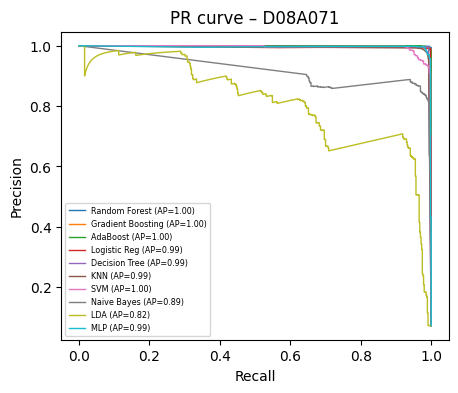

,Precision,Recall,PR-AUC,ConfMatrix
Model,,,,
Random Forest,0.995,0.996,1.000,[[7106 3] [2 555]]
Gradient Boosting,0.991,0.996,1.000,[[7104 5] [2 555]]
AdaBoost,0.995,0.991,1.000,[[7106 3] [5 552]]
SVM,0.964,0.961,0.995,[[7089 20] [22 535]]
MLP,0.998,0.921,0.995,[[7108 1] [44 513]]
Logistic Reg,0.991,0.998,0.994,[[7104 5] [1 556]]
Decision Tree,0.996,0.993,0.990,[[7107 2] [4 553]]
KNN,0.986,0.980,0.986,[[7101 8] [11 546]]
Naive Bayes,0.877,0.946,0.893,[[7035 74] [30 527]]


### D08A084


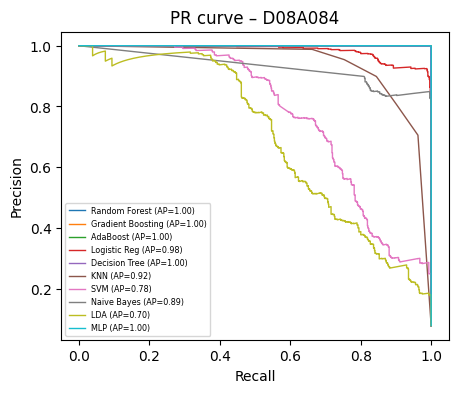

,Precision,Recall,PR-AUC,ConfMatrix
Model,,,,
Random Forest,0.999,0.999,1.000,[[8844 1] [1 745]]
Gradient Boosting,0.999,1.000,1.000,[[8844 1] [0 746]]
AdaBoost,0.999,0.999,1.000,[[8844 1] [1 745]]
MLP,1.000,1.000,1.000,[[8845 0] [0 746]]
Decision Tree,0.999,0.999,0.997,[[8844 1] [1 745]]
Logistic Reg,0.895,0.995,0.985,[[8758 87] [4 742]]
KNN,0.899,0.845,0.915,[[8774 71] [116 630]]
Naive Bayes,0.853,0.830,0.889,[[8738 107] [127 619]]
SVM,0.802,0.570,0.777,[[8740 105] [321 425]]


### D08A115


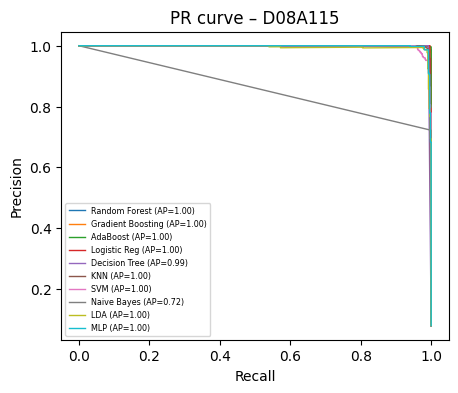

,Precision,Recall,PR-AUC,ConfMatrix
Model,,,,
Random Forest,1.000,0.971,1.000,[[6064 0] [15 504]]
Gradient Boosting,0.998,0.998,1.000,[[6063 1] [1 518]]
AdaBoost,1.000,0.000,1.000,[[6064 0] [519 0]]
Logistic Reg,1.000,0.952,1.000,[[6064 0] [25 494]]
SVM,1.000,0.800,0.998,[[6064 0] [104 415]]
MLP,1.000,0.840,0.998,[[6064 0] [83 436]]
KNN,1.000,0.954,0.996,[[6064 0] [24 495]]
LDA,0.995,0.751,0.995,[[6062 2] [129 390]]
Decision Tree,1.000,0.992,0.993,[[6064 0] [4 515]]


In [7]:
from IPython.display import display

for code in STATIONS:
    df = build_features(load_station(code))
    X, y = df[feat_cols], df['flood']
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_FRAC, random_state=SEED, stratify=y)

    print(f"### {code}")
    tbl = []

    plt.figure(figsize=(5, 4))
    for name, clf in classifiers.items():
        clf.fit(X_tr, y_tr)
        prob  = clf.predict_proba(X_te)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_te)
        pr_auc = average_precision_score(y_te, prob)
        prec_curve, rec_curve, _ = precision_recall_curve(y_te, prob)
        plt.plot(rec_curve, prec_curve, lw=1, label=f"{name} (AP={pr_auc:.2f})")

        thr  = MY_THR[code]
        pred = (prob > thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, pred, labels=[0, 1]).ravel()

        tbl.append({
            'Model': name,
            'Precision': round(precision_score(y_te, pred, zero_division=1), 3),
            'Recall': round(recall_score(y_te, pred), 3),
            'PR-AUC': round(pr_auc, 3),
            'ConfMatrix': f"[[{tn} {fp}] [{fn} {tp}]]"
        })

    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR curve – {code}")
    plt.legend(fontsize="xx-small")
    plt.show()

    display(pd.DataFrame(tbl).set_index("Model").sort_values("PR-AUC", ascending=False))

,rain_sum_3h,rain_sum_6h,rain_sum_12h,dis_lag_1h,dis_lag_2h,dis_lag_3h,dis_lag_4h,dis_lag_5h,dis_lag_6h,dis_lag_7h,dis_lag_8h,dis_lag_9h,dis_lag_10h,dis_lag_11h,dis_lag_12h,dis_rate_1h,dis_rate_3h,API7,label
datetime,,,,,,,,,,,,,,,,,,,
2015-07-24 22:00:00,0.0,0.0,1.4,1.051,1.051,1.051,1.051,1.051,1.051,1.051,1.051,1.051,1.051,1.051,1.051,0.0,0.0,1.4,0
2015-08-21 15:00:00,0.0,0.0,0.0,1.196,1.196,1.196,1.196,1.196,1.196,1.196,1.196,1.196,1.196,1.196,1.196,0.0,0.0,0.0,0
2014-10-03 01:00:00,0.0,0.0,0.0,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.0,0.0,4.8,0
2014-10-06 04:00:00,0.0,0.0,0.0,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.389,0.0,0.0,0.0,0
2019-06-07 13:00:00,0.0,0.0,0.0,2.936,2.936,2.936,2.936,2.936,2.936,2.936,2.936,2.936,2.936,2.936,2.936,0.0,0.0,0.0,0


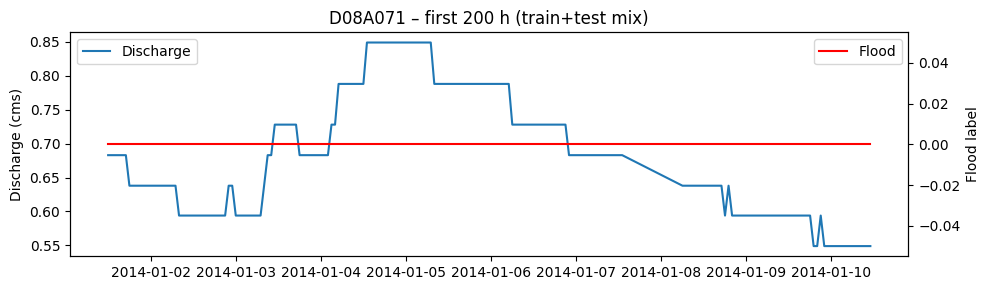

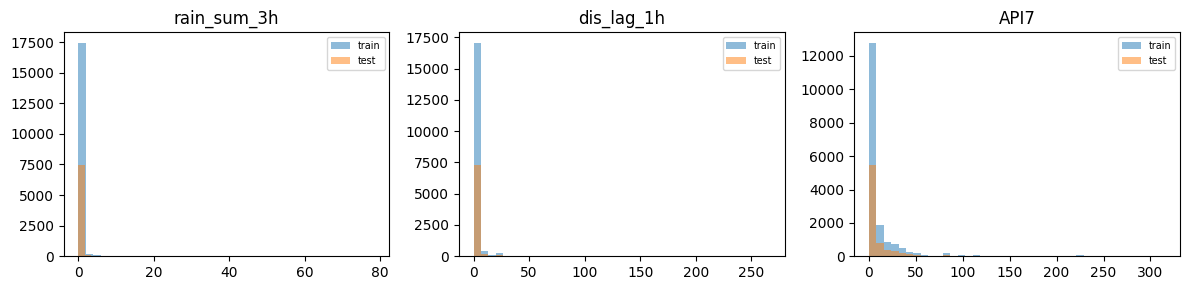

In [8]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║  Quick train / test visualisation for one station               ║
# ╚══════════════════════════════════════════════════════════════════╝
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- choose station -------------------------------------------------
code = 'D08A071'            # 'D08A084' or 'D08A115' also work

# --- build features & split ----------------------------------------
df = build_features(load_station(code))
feature_cols = [c for c in df.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]
X, y = df[feature_cols], df['flood']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y)

# --- 1. show first 5 consecutive train rows ------------------------
sample_5 = pd.concat([X_train.head(5), y_train.head(5).rename('label')], axis=1)
display(sample_5)

# --- 2. time-series snippet (first 200 hours) ----------------------
snippet = df[['discharge_cms', 'flood']].iloc[:200]

fig, ax1 = plt.subplots(figsize=(10, 3))
ax1.plot(snippet.index, snippet['discharge_cms'], label='Discharge')
ax1.set_ylabel('Discharge (cms)')
ax2 = ax1.twinx()
ax2.step(snippet.index, snippet['flood'], where='post', color='red', label='Flood')
ax2.set_ylabel('Flood label')
plt.title(f"{code} – first 200 h (train+test mix)")
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.tight_layout(); plt.show()

# --- 3. feature distributions train vs test ------------------------
features_to_show = ['rain_sum_3h', 'dis_lag_1h', 'API7']  # edit as you like
fig, axes = plt.subplots(1, len(features_to_show), figsize=(4*len(features_to_show), 3))

for ax, feat in zip(axes, features_to_show):
    ax.hist(X_train[feat], bins=40, alpha=0.5, label='train')
    ax.hist(X_test[feat],  bins=40, alpha=0.5, label='test')
    ax.set_title(feat); ax.legend(fontsize='x-small')

plt.tight_layout(); plt.show()